In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import sklearn as sklearn
import multiprocessing

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import RandomTreesEmbedding
from sklearn.neural_network import MLPRegressor
#from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import Imputer
from sklearn import metrics

import statsmodels.api as sm
from keras import optimizers
from sklearn.linear_model import SGDRegressor
#import statsmodels.api as sm


from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1

import copy

# NN parameters
NUM_ITERATIONS = 300
BATCH_SIZE = 256
LEARNING_RATE = 0.001
LASSO_COEF = 50.0
DECAY_RATE = 0.0001

plt.style.use("ggplot")
n_cores = multiprocessing.cpu_count() # Getting the number of cores for multiprocessing

def get_gaussian_process_regressor():
    gp = GaussianProcessRegressor()
    return [gp], ['Gaussian Process']


def get_mlp_regressor(num_hidden_units=51):
    mlp = MLPRegressor(hidden_layer_sizes=num_hidden_units)
    return [mlp], ['Multi-Layer Perceptron']


def get_ensemble_models():
    grad = GradientBoostingRegressor(n_estimators=17, random_state=42, loss='lad', learning_rate=0.12, max_depth=10)
    classifier_list = [grad]
    classifier_name_list = ['Gradient Boost']
    return classifier_list, classifier_name_list


def print_evaluation_metrics(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' ---------\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))



def print_evaluation_metrics2(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' --------- (Train Data)\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))


def svm(X_train, y_train, X_val, y_val):
    model = SVR(gamma = 0.05, verbose = True) #was empty #0.1 #the - best gamma 0.05, c=0.5
    model.fit(X_train, y_train)
    print_evaluation_metrics(model, "svm", X_val, y_val.values.ravel())
    print_evaluation_metrics2(model, "svm", X_train, y_train.values.ravel())

def LinearModel(X_train, y_train, X_val, y_val):
    regr = linear_model.LinearRegression(n_jobs=int(0.8*n_cores)).fit(X_train, y_train)
    print_evaluation_metrics(regr, "linear model", X_val, y_val.values.ravel())
    print_evaluation_metrics2(regr, "linear model", X_train, y_train.values.ravel())

    return


def LinearModelRidge(X_train, y_train, X_val, y_val):
    regr = Ridge(alpha = 7) #7
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_val.values)

    print('Coefficients: \n', regr.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
    print('Variance score: %.2f' % r2_score(y_val, y_pred))
    print("R2:", sklearn.metrics.r2_score(y_val, y_pred))

    print_evaluation_metrics(regr, "Linear Model Ridge", X_val, y_val)
    print_evaluation_metrics2(regr, "Linear Model Ridge", X_train, y_train)
    return

def LinearModelLasso(X_train, y_train, X_val, y_val):
    regr = Lasso(alpha = 0.5) #0.5
    regr.fit(X_train, y_train)

    print_evaluation_metrics(regr, "Linear Model Lasso", X_val, y_val)
    print_evaluation_metrics2(regr, "Linear Model Lasso", X_train, y_train)
    return



def simple_neural_network(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(Dense(units=20, activation='relu', input_dim=len(X_train.values[0])))
    model.add(Dense(units=5, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    adam = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=DECAY_RATE, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(X_train, y_train, epochs=NUM_ITERATIONS, batch_size=BATCH_SIZE)
    print("finished fitting")
    print_evaluation_metrics(model, "NN", X_val, y_val)
    print_evaluation_metrics2(model, "NN", X_train, y_train)
    return


def TreebasedModel(X_train, y_train, X_val, y_val):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    y_train = np.squeeze(y_train)
    y_val = np.squeeze(y_val)

    classifier_list, classifier_name_list = get_ensemble_models()
    for classifier, classifier_name in zip(classifier_list, classifier_name_list):
        classifier.fit(X_train, y_train)
        print_evaluation_metrics(classifier, classifier_name, X_val, y_val)
        print_evaluation_metrics2(classifier, classifier_name, X_train, y_train)
    return


def kmeans(X_train, y_train, X_val, y_val):
    n_clusters = 8
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, n_jobs=int(0.8*n_cores)).fit(X_train)
    c_train = kmeans.predict(X_train)
    c_pred = kmeans.predict(X_val)
    centroids = kmeans.cluster_centers_
    y_val_stats = None
    predicted_values = None
    y_train_stats = None
    labels_stats = None
    for i in range(n_clusters):
        print('--------analyzing cluster %d--------' %i)
        train_mask = c_train==i
        std_train = np.std(y_train[train_mask])
        mean_train = np.mean(y_train[train_mask])
        print("# examples & price mean & std for training set within cluster %d is:(%d, %.2f, %.2f)" %(i, train_mask.sum(), np.float(mean_train), np.float(std_train)))
        pred_mask = c_pred==i
        std_pred = np.std(y_val[pred_mask])
        mean_pred = np.mean(y_val[pred_mask])
        print("# examples & price mean & std for validation set within cluster %d is:(%d, %.2f, %.2f)" %(i, pred_mask.sum(), np.float(mean_pred), np.float(std_pred)))
        if pred_mask.sum() == 0:
            print('Zero membered test set! Skipping the test and training validation.')
            continue
        #LinearModelRidge(X_train[train_mask], y_train[train_mask], X_val[pred_mask], y_val[pred_mask])
        regr = Ridge(alpha = 7) #7
        regr.fit(X_train[train_mask], y_train[train_mask])
        labels_pred = regr.predict(X_train[train_mask].values)
        y_pred = regr.predict(X_val[pred_mask].values)
        if (y_val_stats is None):
            y_val_stats = copy.deepcopy(y_val[pred_mask])
            y_train_stats = copy.deepcopy(y_train[train_mask])
            predicted_values = copy.deepcopy(y_pred)
            labels_stats = copy.deepcopy(labels_pred)

        else:
            y_val_stats = y_val_stats.append(y_val[pred_mask])
            y_train_stats = y_train_stats.append(y_train[train_mask])
            predicted_values = np.append(predicted_values, y_pred)
            labels_stats = np.append(labels_stats, labels_pred)
        print('--------Finished analyzing cluster %d--------' %i)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_val_stats, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_val_stats, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_val_stats, predicted_values))
    print("R2: ", metrics.r2_score(y_val_stats, predicted_values))
    print('------------TRAIN--------------------')
    print("Mean absolute error: ",
        metrics.mean_absolute_error(y_train_stats, labels_stats))
    print("Median absolute error: ",
        metrics.median_absolute_error(y_train_stats, labels_stats))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_train_stats, labels_stats))
    print("R2: ", metrics.r2_score(y_train_stats, labels_stats))


    return c_pred, centroids


def linear_model_SGD(X_train, y_train, X_val, y_val):
    model = SGDRegressor()
    model.fit(X_train, y_train)
    print_evaluation_metrics(model, "sgd", X_val, y_val.values.ravel())
    print_evaluation_metrics2(model, "sgd", X_train, y_train.values.ravel())


X_train = pd.read_csv('./Data/data_cleaned_train_comments_X.csv')
y_train = pd.read_csv('./Data/data_cleaned_train_y.csv')

X_val = pd.read_csv('./Data/data_cleaned_val_comments_X.csv')
y_val = pd.read_csv('./Data/data_cleaned_val_y.csv')

X_test = pd.read_csv('./Data/data_cleaned_test_comments_X.csv')
y_test = pd.read_csv('./Data/data_cleaned_test_y.csv')

#coeffs = np.load('./Data/selected_coefs_pvals.npy')
coeffs = np.load('./Data/selected_coefs.npy')
col_set = set()
cherry_picked_list = [
'host_identity_verified',
'latitude',
'longitude',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'guests_included',
'security_deposit',
'cleaning_fee',
'extra_people',
'number_of_reviews',
'review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_location',
'review_scores_value',
'reviews_per_month',
'comments'
]
for i in range(len(coeffs)):
    if (coeffs[i]):
        col_set.add(X_train.columns[i])
X_train = X_train[list(col_set)]
X_val = X_val[list(col_set)]
X_test = X_test[list(col_set)]

X_concat = pd.concat([X_train, X_val], ignore_index=True)
y_concat = pd.concat([y_train, y_val], ignore_index=True)

#RUN WITHOUT FEATURE SELECTION FOR THE BASELINE
"""
print("--------------------Linear Regression--------------------")
LinearModel(X_concat, y_concat, X_test, y_test)
"""

print("--------------------Tree-based Model--------------------")
TreebasedModel(X_concat, y_concat, X_test, y_test)
print("--------------------KMeans Clustering--------------------")
c_pred, centroids = kmeans(X_concat, y_concat, X_test, y_test)




print("--------------------------------------------------")
LinearModelRidge(X_concat, y_concat, X_test, y_test)
print("--------------------------------------------------")

print("--------------------------------------------------")
#LinearModelLasso(X_train, y_train, X_val, y_val)
print("--------------------------------------------------")
simple_neural_network(X_concat, y_concat, X_test, y_test)

svm(X_concat, y_concat, X_test, y_test)

--------------------Tree-based Model--------------------
--------- For Model:  Gradient Boost  ---------

Mean absolute error:  0.30695170392311955
Median absolute error:  0.2169206954173606
Mean squared error:  0.21902877236848617
R2:  0.5486774994301904
--------- For Model:  Gradient Boost  --------- (Train Data)

Mean absolute error:  0.244258460810186
Median absolute error:  0.13995899438581505
Mean squared error:  0.18303477896350212
R2:  0.6552639708218508
--------------------KMeans Clustering--------------------
--------analyzing cluster 0--------
# examples & price mean & std for training set within cluster 0 is:(1419, 6.61, 0.65)
# examples & price mean & std for validation set within cluster 0 is:(167, 6.65, 0.63)
--------Finished analyzing cluster 0--------
--------analyzing cluster 1--------
# examples & price mean & std for training set within cluster 1 is:(1513, 6.17, 0.60)
# examples & price mean & std for validation set within cluster 1 is:(167, 6.16, 0.59)
--------Fini

11284/11284 [==============================] - 0s 16us/step - loss: 0.2133
Epoch 112/300
11284/11284 [==============================] - 0s 15us/step - loss: 0.2138
Epoch 113/300
11284/11284 [==============================] - 0s 16us/step - loss: 0.2108
Epoch 114/300
11284/11284 [==============================] - 0s 17us/step - loss: 0.2103
Epoch 115/300
11284/11284 [==============================] - 0s 21us/step - loss: 0.2090
Epoch 116/300
11284/11284 [==============================] - 0s 25us/step - loss: 0.2086
Epoch 117/300
11284/11284 [==============================] - 0s 25us/step - loss: 0.2072
Epoch 118/300
11284/11284 [==============================] - 0s 26us/step - loss: 0.2073
Epoch 119/300
11284/11284 [==============================] - 0s 18us/step - loss: 0.2070
Epoch 120/300
11284/11284 [==============================] - 0s 28us/step - loss: 0.2059
Epoch 121/300
11284/11284 [==============================] - 0s 28us/step - loss: 0.2062
Epoch 122/300
11284/11284 [========

11284/11284 [==============================] - 0s 15us/step - loss: 0.1709
Epoch 204/300
11284/11284 [==============================] - 0s 16us/step - loss: 0.1715
Epoch 205/300
11284/11284 [==============================] - 0s 21us/step - loss: 0.1702
Epoch 206/300
11284/11284 [==============================] - 0s 23us/step - loss: 0.1699
Epoch 207/300
11284/11284 [==============================] - 0s 23us/step - loss: 0.1698
Epoch 208/300
11284/11284 [==============================] - 0s 20us/step - loss: 0.1695
Epoch 209/300
11284/11284 [==============================] - 0s 23us/step - loss: 0.1692
Epoch 210/300
11284/11284 [==============================] - 0s 23us/step - loss: 0.1697
Epoch 211/300
11284/11284 [==============================] - 0s 19us/step - loss: 0.1690
Epoch 212/300
11284/11284 [==============================] - 0s 16us/step - loss: 0.1685
Epoch 213/300
11284/11284 [==============================] - 0s 17us/step - loss: 0.1684
Epoch 214/300
11284/11284 [========

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------- For Model:  svm  ---------

Mean absolute error:  0.2778089151403522
Median absolute error:  0.1839645388234219
Mean squared error:  0.1968092014941264
R2:  0.5944623165579288
--------- For Model:  svm  --------- (Train Data)

Mean absolute error:  0.19409219816802234
Median absolute error:  0.10019903825232257
Mean squared error:  0.13190378627161356
R2:  0.7515664084697988


AttributeError: 'function' object has no attribute 'feature_importances_'

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import sklearn as sklearn
import multiprocessing

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import RandomTreesEmbedding
from sklearn.neural_network import MLPRegressor
#from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import Imputer
from sklearn import metrics

import statsmodels.api as sm
from keras import optimizers
from sklearn.linear_model import SGDRegressor
#import statsmodels.api as sm


from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1

import copy

# NN parameters
NUM_ITERATIONS = 300
BATCH_SIZE = 256
LEARNING_RATE = 0.001
LASSO_COEF = 50.0
DECAY_RATE = 0.0001

plt.style.use("ggplot")
n_cores = multiprocessing.cpu_count() # Getting the number of cores for multiprocessing

def get_gaussian_process_regressor():
    gp = GaussianProcessRegressor()
    return [gp], ['Gaussian Process']


def get_mlp_regressor(num_hidden_units=51):
    mlp = MLPRegressor(hidden_layer_sizes=num_hidden_units)
    return [mlp], ['Multi-Layer Perceptron']


def get_ensemble_models():
    grad = GradientBoostingRegressor(n_estimators=17, random_state=42, loss='lad', learning_rate=0.12, max_depth=10)
    classifier_list = [grad]
    classifier_name_list = ['Gradient Boost']
    return classifier_list, classifier_name_list


def print_evaluation_metrics(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' ---------\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))



def print_evaluation_metrics2(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' --------- (Train Data)\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))


def svm(X_train, y_train, X_val, y_val):
    model = SVR(gamma = 0.05, verbose = True) #was empty #0.1 #the - best gamma 0.05, c=0.5
    model.fit(X_train, y_train)
    print_evaluation_metrics(model, "svm", X_val, y_val.values.ravel())
    print_evaluation_metrics2(model, "svm", X_train, y_train.values.ravel())

def LinearModel(X_train, y_train, X_val, y_val):
    regr = linear_model.LinearRegression(n_jobs=int(0.8*n_cores)).fit(X_train, y_train)
    print_evaluation_metrics(regr, "linear model", X_val, y_val.values.ravel())
    print_evaluation_metrics2(regr, "linear model", X_train, y_train.values.ravel())

    return


def LinearModelRidge(X_train, y_train, X_val, y_val):
    regr = Ridge(alpha = 7) #7
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_val.values)

    print('Coefficients: \n', regr.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
    print('Variance score: %.2f' % r2_score(y_val, y_pred))
    print("R2:", sklearn.metrics.r2_score(y_val, y_pred))

    print_evaluation_metrics(regr, "Linear Model Ridge", X_val, y_val)
    print_evaluation_metrics2(regr, "Linear Model Ridge", X_train, y_train)
    return

def LinearModelLasso(X_train, y_train, X_val, y_val):
    regr = Lasso(alpha = 0.5) #0.5
    regr.fit(X_train, y_train)

    print_evaluation_metrics(regr, "Linear Model Lasso", X_val, y_val)
    print_evaluation_metrics2(regr, "Linear Model Lasso", X_train, y_train)
    return



def simple_neural_network(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(Dense(units=20, activation='relu', input_dim=len(X_train.values[0])))
    model.add(Dense(units=5, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    adam = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=DECAY_RATE, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.fit(X_train, y_train, epochs=NUM_ITERATIONS, batch_size=BATCH_SIZE)
    print("finished fitting")
    print_evaluation_metrics(model, "NN", X_val, y_val)
    print_evaluation_metrics2(model, "NN", X_train, y_train)
    return


def kmeans(X_train, y_train, X_val, y_val):
    n_clusters = 8
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, n_jobs=int(0.8*n_cores)).fit(X_train)
    c_train = kmeans.predict(X_train)
    c_pred = kmeans.predict(X_val)
    centroids = kmeans.cluster_centers_
    y_val_stats = None
    predicted_values = None
    y_train_stats = None
    labels_stats = None
    for i in range(n_clusters):
        print('--------analyzing cluster %d--------' %i)
        train_mask = c_train==i
        std_train = np.std(y_train[train_mask])
        mean_train = np.mean(y_train[train_mask])
        print("# examples & price mean & std for training set within cluster %d is:(%d, %.2f, %.2f)" %(i, train_mask.sum(), np.float(mean_train), np.float(std_train)))
        pred_mask = c_pred==i
        std_pred = np.std(y_val[pred_mask])
        mean_pred = np.mean(y_val[pred_mask])
        print("# examples & price mean & std for validation set within cluster %d is:(%d, %.2f, %.2f)" %(i, pred_mask.sum(), np.float(mean_pred), np.float(std_pred)))
        if pred_mask.sum() == 0:
            print('Zero membered test set! Skipping the test and training validation.')
            continue
        #LinearModelRidge(X_train[train_mask], y_train[train_mask], X_val[pred_mask], y_val[pred_mask])
        regr = Ridge(alpha = 7) #7
        regr.fit(X_train[train_mask], y_train[train_mask])
        labels_pred = regr.predict(X_train[train_mask].values)
        y_pred = regr.predict(X_val[pred_mask].values)
        if (y_val_stats is None):
            y_val_stats = copy.deepcopy(y_val[pred_mask])
            y_train_stats = copy.deepcopy(y_train[train_mask])
            predicted_values = copy.deepcopy(y_pred)
            labels_stats = copy.deepcopy(labels_pred)

        else:
            y_val_stats = y_val_stats.append(y_val[pred_mask])
            y_train_stats = y_train_stats.append(y_train[train_mask])
            predicted_values = np.append(predicted_values, y_pred)
            labels_stats = np.append(labels_stats, labels_pred)
        print('--------Finished analyzing cluster %d--------' %i)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_val_stats, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_val_stats, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_val_stats, predicted_values))
    print("R2: ", metrics.r2_score(y_val_stats, predicted_values))
    print('------------TRAIN--------------------')
    print("Mean absolute error: ",
        metrics.mean_absolute_error(y_train_stats, labels_stats))
    print("Median absolute error: ",
        metrics.median_absolute_error(y_train_stats, labels_stats))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_train_stats, labels_stats))
    print("R2: ", metrics.r2_score(y_train_stats, labels_stats))


    return c_pred, centroids


X_train = pd.read_csv('./Data/data_cleaned_train_comments_X.csv')
y_train = pd.read_csv('./Data/data_cleaned_train_y.csv')


X_val = pd.read_csv('./Data/data_cleaned_val_comments_X.csv')
y_val = pd.read_csv('./Data/data_cleaned_val_y.csv')

X_test = pd.read_csv('./Data/data_cleaned_test_comments_X.csv')
y_test = pd.read_csv('./Data/data_cleaned_test_y.csv')

#coeffs = np.load('./Data/selected_coefs_pvals.npy')
coeffs = np.load('./Data/selected_coefs.npy')
col_set = set()
cherry_picked_list = [
'host_identity_verified',
'latitude',
'longitude',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'guests_included',
'security_deposit',
'cleaning_fee',
'extra_people',
'number_of_reviews',
'review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_location',
'review_scores_value',
'reviews_per_month',
'comments'
]
for i in range(len(coeffs)):
    if (coeffs[i]):
        col_set.add(X_train.columns[i])
X_train = X_train[list(col_set)]
X_val = X_val[list(col_set)]
X_test = X_test[list(col_set)]

names = X_train.columns

X_concat = pd.concat([X_train, X_val], ignore_index=True)
y_concat = pd.concat([y_train, y_val], ignore_index=True)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

classifier_list, classifier_name_list = get_ensemble_models()
for classifier, classifier_name in zip(classifier_list, classifier_name_list):
    classifier.fit(X_train, y_train)
    print_evaluation_metrics(classifier, classifier_name, X_val, y_val)
    print_evaluation_metrics2(classifier, classifier_name, X_train, y_train)


--------- For Model:  Gradient Boost  ---------

Mean absolute error:  0.33245068516158716
Median absolute error:  0.23751655707458363
Mean squared error:  0.24872417487704995
R2:  0.5291562361029283
--------- For Model:  Gradient Boost  --------- (Train Data)

Mean absolute error:  0.23912367396239975
Median absolute error:  0.13552098692747316
Mean squared error:  0.17653910890693886
R2:  0.6677047101425506


[1.99381576e-03 2.69980120e-03 2.97197239e-03 2.73151150e-04
 1.36459962e-02 2.26500665e-03 1.32032036e-03 2.65616817e-03
 1.12189712e-03 0.00000000e+00 2.19449082e-02 2.00584026e-03
 0.00000000e+00 6.75634066e-04 1.32466837e-03 6.43549027e-03
 4.35290580e-04 4.22419291e-04 6.01543817e-04 2.74101198e-03
 2.95249418e-03 5.94687917e-04 8.78189564e-04 9.95476844e-04
 4.14746329e-04 1.27205889e-04 3.64898928e-03 4.69320197e-04
 1.59018092e-03 1.53034641e-03 1.86202046e-03 2.41555522e-04
 1.40789216e-03 2.46462479e-03 1.92522734e-03 1.51025193e-03
 7.58771265e-04 1.74974172e-03 3.36596948e-04 1.37250131e-04
 1.81911301e-04 3.08968462e-03 1.73603296e-04 4.26203747e-03
 2.84018101e-04 2.31684354e-03 1.48984058e-03 1.59163466e-03
 4.64663061e-05 1.27158818e-04 1.12817737e-02 2.13302691e-04
 1.46156384e-02 2.19925482e-02 4.55374204e-04 3.09192651e-03
 2.79990397e-04 1.05768064e-02 1.47914315e-03 1.70867756e-03
 4.86406577e-04 6.78763881e-04 7.78097725e-02 3.94126021e-03
 3.18497550e-03 2.459730

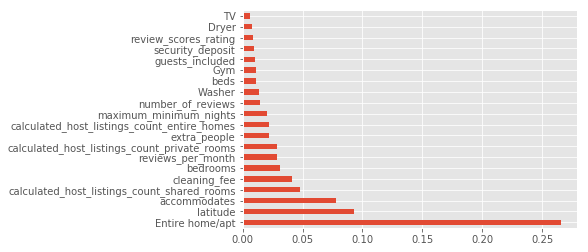

In [11]:
print(classifier.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(classifier.feature_importances_, index=names)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [18]:
from xgboost import XGBRegressor
import eli5
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(5, shuffle=True, random_state = 91)
cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_val)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_xgb_base, y_train)]})

[23:27:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:30:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:31:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


NameError: name 'X_yal' is not defined

[2.9175638e-03 1.6082498e-03 1.8303804e-03 2.7237213e-04 7.1339635e-03
 7.7855163e-03 2.7668700e-03 2.3216915e-03 3.3535641e-03 1.2915227e-02
 3.1951072e-03 3.2167507e-03 9.8162610e-04 3.9246450e-03 1.4557699e-03
 1.8884825e-02 8.9008203e-03 4.7805738e-03 2.5423270e-04 2.6910198e-03
 9.5645888e-03 7.7624089e-04 1.4497326e-03 4.0775985e-03 1.4030021e-04
 4.2148423e-04 2.3792216e-03 6.7701745e-03 4.5096846e-03 7.6698390e-04
 7.3628966e-03 2.8361704e-03 1.0049351e-03 6.2589603e-03 3.5062050e-03
 3.1912157e-03 0.0000000e+00 1.1779693e-03 0.0000000e+00 0.0000000e+00
 6.6760468e-04 3.4387666e-03 6.3975481e-04 5.1764105e-03 0.0000000e+00
 1.5675947e-02 1.9202358e-03 3.2654977e-03 0.0000000e+00 1.3086374e-03
 7.2095310e-03 8.0049824e-04 2.4777986e-03 4.4933013e-03 3.4941643e-04
 3.4893309e-03 0.0000000e+00 9.4194366e-03 3.0226302e-03 1.6245458e-03
 2.8957305e-03 1.7743412e-03 3.5991862e-02 6.5572620e-03 1.3786310e-03
 1.0642223e-03 1.4664187e-03 6.3318610e-03 2.4484447e-03 5.0845109e-03
 2.127

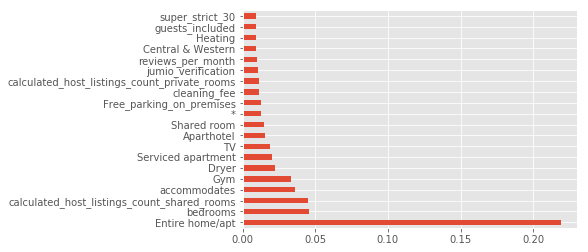

In [21]:
print(xgb_baseline.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(xgb_baseline.feature_importances_, index=names)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [22]:
print(xgb_baseline)
xgb_baseline_results

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


,algorithm,CV error,CV std,training error
0,XGBRegressor[baseline],-0.196454,0.019311,0.143523


In [28]:
d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in [0.01, 0.05, 0.1, 0.5]:
    #continue
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    # makes no sense to look at max/min when we only have 3 CV folds
    #d['Max CV Error'].append(max(cv_res)
    #d['Min CV Error'].append(max(cv_res)
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

# to run the search, comment out 'continue' in the for loop

xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1

[23:41:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:46:36] WARNI

,Learning Rate,Mean CV Error,CV Error Std,Training Error
0,0.01,0.226821,0.016110,0.203375
1,0.05,0.194289,0.010939,0.143523
2,0.10,0.189127,0.011033,0.109713
3,0.50,0.214648,0.008937,0.035848


Text(0, 0.5, 'Mean Squared Error')

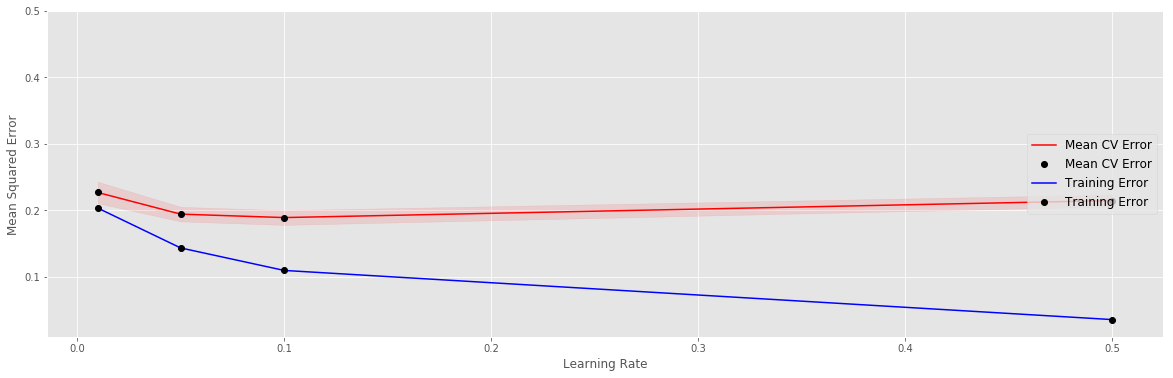

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], color='red')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], 'o', color='black')
ax.fill_between(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'] - xgb_tuning_1['CV Error Std'], xgb_tuning_1['Mean CV Error'] + xgb_tuning_1['CV Error Std'], color='r', alpha=.1)
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], color='blue')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], 'o', color='black')
ax.legend(fontsize=12, loc = 'center right');
ax.set_ylim(0.01, 0.5)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Squared Error')
#ax.set_title('')

In [32]:
d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
xgbreg = XGBRegressor(n_estimators=2, learning_rate=0.05, early_stopping=5)
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}
#print(params2)
#xgb_random.fit(X_train, y_train)
kf = KFold(3, shuffle=True, random_state = 91).get_n_splits(X_train)
for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        #continue
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        # makes no sense to look at max/min when we only have 3 CV folds
        #d['Max CV Error'].append(max(cv_res)
        #d['Min CV Error'].append(max(cv_res)
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

#print(d)

# to run the search, comment out 'continue' in the for loop
        
xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2

[00:12:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:15:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:47] WARNI

,max_depth,min_child_weight,Mean CV Error,CV Error Std,Training Error
0,3,1,0.193199,0.005228,0.109713
1,3,3,0.193298,0.003074,0.108564
2,3,5,0.193134,0.004537,0.111182
3,5,1,0.189361,0.004816,0.033772
4,5,3,0.188921,0.004069,0.034970
5,5,5,0.189729,0.005973,0.040590
6,7,1,0.188362,0.005824,0.004708
7,7,3,0.189293,0.006277,0.005529
8,7,5,0.191226,0.008457,0.008087
9,9,1,0.191596,0.003441,0.000302


In [33]:
print('Optimal parameter values are: ')
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

Optimal parameter values are: 
max_depth: 9
min_child_weight: 5


In [39]:
def rmse_cv(model):
    kf = KFold(5, shuffle=True, random_state = 91)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [40]:
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=9, min_child_weight=5)
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_val)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

[09:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:46:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178'] ['Hair_dryer', 'Laptop_friendly_workspace', 'Family/kid_friendly', '佐敦', 'Washer', 'Wifi', 'Hostel', 'review_scores_location', 'Lockbox', '*', 'calculated_host_listings_count_entire_homes', 'Buzzer/wireless_intercom', 'Houseboat', 'Room-darkening_shades', 'Eastern', 'TV', 'Tsuen Wan.1', 'sesame_verification', 'Wide_entrance', 'Doorman', 'Heating', 'Pocket_wifi', 'Kowloon', 'Air_conditioning', 'Flat_path_to_guest_entrance', '深圳市', 'flexible', 'phone_verification', 'work_email_verification', 'Guest suite', 'Pets_allowed', 'super_strict_60', 'Patio_or_balcony', 'reviews_verification', 'Breakfast', 'government_id_verification', 'manual_offline_verification', 'host_identity_verified', 'Shenzhen', 'Children’s_dinnerware', '_toilet', 'Iron', 'Roll-in_shower', 'Smoke_detector', 'Wide_entryway', 'Aparthotel', 'Hot_tub', 'selfie_verification', 'Babysitter_recommendations', 'High_chair', 'beds', 'Ethernet_connection', 'number_of_reviews', 'extra_people', 'Waterfront', 'Shampoo', 'North.1', 'guests_included', 'Private_living_room', '24-hour_check-in', 'BBQ_grill', 'within a day', 'accommodates', 'Suitable_for_events', 'Hangers', '油麻地', 'Beachfront', '香港', 'review_scores_checkin', 'maximum_minimum_nights', 'Dishwasher', 'Long_term_stays_allowed', 'Elevator', 'weibo_verification', 'jumio_verification', 'Smoking_allowed', 'bedrooms', 'Lamma Island', 'Sha Tin', 'Paid_parking_off_premises', 'Accessible-height_toilet', 'Kwai Tsing', 'review_scores_communication', 'Shared room', 'Shenzhen Shi', 'Entire home/apt', 'identity_manual_verification', 'latitude', 'Coffee_maker', 'Carbon_monoxide_detector', 'Serviced apartment', 'Cable_TV', 'Fire_extinguisher', 'Hong Kong', 'instant_bookable', 'Boutique hotel', 'Paid_parking_on_premises', 'cleaning_fee', 'google_verification', 'offline_government_id_verification', 'Free_street_parking', 'calculated_host_listings_count_private_rooms', 'Condominium', 'House', 'require_guest_profile_picture', 'Villa', 'TSIM Sha Tsui', 'Wide_hallways', 'Kwun Tong.1', 'Hong Kong Island', 'review_scores_value', 'Wide_clearance_to_shower', 'Causeway Bay', 'review_scores_rating', 'facebook_verification', 'Baby_bath', 'calculated_host_listings_count_shared_rooms', 'Gym', 'Luggage_dropoff_allowed', 'Other', 'email_verification', 'zhima_selfie_verification', 'Free_parking_on_premises', 'Guesthouse', 'Yuen Long.1', 'Self_check-in', 'Sai Kung.1', 'Changing_table', 'Other.1', 'Well-lit_path_to_entrance', 'sesame_offline_verification', 'within an hour', 'review_scores_accuracy', 'Kitchen', 'Wan Chai.1', 'host_is_superhost', 'Central', 'Pool', 'Lock_on_bedroom_door', 'Central & Western', 'Kowloon City', 'Couch', 'a few days or more', 'Game_console', 'Hot_water', 'Dryer', 'Sham Shui Po.1', 'Southern', 'Bathtub', 'Mongkok', 'Real Bed', 'Cleaning_before_checkout', 'Wan Chai', 'Host_greets_you', 'Apartment', 'Hotel', 'Safety_card', '彌敦道', 'security_deposit', 'review_scores_cleanliness', 'Microwave', 'Pets_live_on_this_property', 'super_strict_30', 'Bed_linens', 'First_aid_kit', 'Fixed_grab_bars_for_toilet', 'Oven', 'Keypad', 'reviews_per_month', 'Jordan', 'within a few hours', 'Stove', 'Crib', 'Islands', 'Essentials', 'Single_level_home', 'Refrigerator', 'Boat', '并']
expected f6, f4, f170, f172, f8, f146, f149, f171, f160, f70, f123, f96, f155, f105, f174, f151, f119, f111, f25, f165, f158, f17, f42, f173, f33, f27, f53, f153, f55, f30, f130, f29, f143, f47, f142, f103, f3, f75, f21, f108, f141, f154, f26, f77, f86, f50, f13, f20, f97, f89, f129, f138, f14, f133, f71, f73, f91, f107, f9, f74, f62, f52, f98, f58, f126, f46, f32, f92, f145, f152, f37, f101, f117, f0, f132, f104, f63, f72, f84, f166, f80, f57, f68, f163, f69, f41, f38, f49, f40, f10, f48, f22, f67, f127, f76, f175, f159, f162, f109, f120, f148, f168, f137, f39, f176, f134, f131, f35, f36, f125, f90, f19, f56, f61, f113, f106, f139, f28, f23, f177, f65, f156, f93, f164, f136, f34, f78, f24, f178, f102, f110, f115, f112, f116, f122, f85, f167, f147, f81, f161, f66, f11, f87, f43, f135, f60, f144, f15, f2, f169, f128, f44, f51, f118, f16, f157, f114, f150, f7, f82, f12, f124, f83, f95, f31, f94, f1, f45, f99, f100, f18, f59, f121, f54, f64, f140, f79, f88, f5 in input data
training data did not have the following fields: Hair_dryer, Laptop_friendly_workspace, Family/kid_friendly, 佐敦, Washer, Wifi, Hostel, review_scores_location, Lockbox, *, calculated_host_listings_count_entire_homes, Buzzer/wireless_intercom, Houseboat, Room-darkening_shades, Eastern, TV, Tsuen Wan.1, sesame_verification, Wide_entrance, Doorman, Heating, Pocket_wifi, Kowloon, Air_conditioning, Flat_path_to_guest_entrance, 深圳市, flexible, phone_verification, work_email_verification, Guest suite, Pets_allowed, super_strict_60, Patio_or_balcony, reviews_verification, Breakfast, government_id_verification, manual_offline_verification, host_identity_verified, Shenzhen, Children’s_dinnerware, _toilet, Iron, Roll-in_shower, Smoke_detector, Wide_entryway, Aparthotel, Hot_tub, selfie_verification, Babysitter_recommendations, High_chair, beds, Ethernet_connection, number_of_reviews, extra_people, Waterfront, Shampoo, North.1, guests_included, Private_living_room, 24-hour_check-in, BBQ_grill, within a day, accommodates, Suitable_for_events, Hangers, 油麻地, Beachfront, 香港, review_scores_checkin, maximum_minimum_nights, Dishwasher, Long_term_stays_allowed, Elevator, weibo_verification, jumio_verification, Smoking_allowed, bedrooms, Lamma Island, Sha Tin, Paid_parking_off_premises, Accessible-height_toilet, Kwai Tsing, review_scores_communication, Shared room, Shenzhen Shi, Entire home/apt, identity_manual_verification, latitude, Coffee_maker, Carbon_monoxide_detector, Serviced apartment, Cable_TV, Fire_extinguisher, Hong Kong, instant_bookable, Boutique hotel, Paid_parking_on_premises, cleaning_fee, google_verification, offline_government_id_verification, Free_street_parking, calculated_host_listings_count_private_rooms, Condominium, House, require_guest_profile_picture, Villa, TSIM Sha Tsui, Wide_hallways, Kwun Tong.1, Hong Kong Island, review_scores_value, Wide_clearance_to_shower, Causeway Bay, review_scores_rating, facebook_verification, Baby_bath, calculated_host_listings_count_shared_rooms, Gym, Luggage_dropoff_allowed, Other, email_verification, zhima_selfie_verification, Free_parking_on_premises, Guesthouse, Yuen Long.1, Self_check-in, Sai Kung.1, Changing_table, Other.1, Well-lit_path_to_entrance, sesame_offline_verification, within an hour, review_scores_accuracy, Kitchen, Wan Chai.1, host_is_superhost, Central, Pool, Lock_on_bedroom_door, Central & Western, Kowloon City, Couch, a few days or more, Game_console, Hot_water, Dryer, Sham Shui Po.1, Southern, Bathtub, Mongkok, Real Bed, Cleaning_before_checkout, Wan Chai, Host_greets_you, Apartment, Hotel, Safety_card, 彌敦道, security_deposit, review_scores_cleanliness, Microwave, Pets_live_on_this_property, super_strict_30, Bed_linens, First_aid_kit, Fixed_grab_bars_for_toilet, Oven, Keypad, reviews_per_month, Jordan, within a few hours, Stove, Crib, Islands, Essentials, Single_level_home, Refrigerator, Boat, 并

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.180716,0.008058,0.001242,0.908462,0.997662,-0.871942


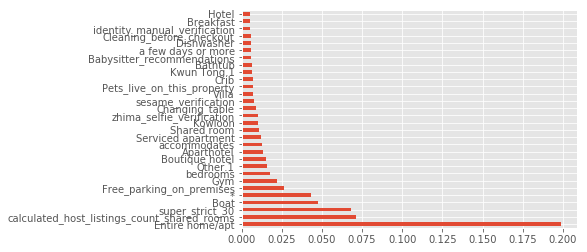

In [45]:
#print(xbgreg_best.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(xbgreg_best.feature_importances_, index=names)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [48]:
eli5.show_weights(xbgreg_best, feature_names=list(names))

Weight,Feature
0.1986,Entire home/apt
0.0710,calculated_host_listings_count_shared_rooms
0.0683,super_strict_30
0.0475,Boat
0.0430,*
0.0262,Free_parking_on_premises
0.0220,Gym
0.0175,bedrooms
0.0160,Other.1
0.0153,Boutique hotel
